In [1]:
# for dev
%load_ext autoreload
%autoreload 2

In [2]:
import ast
import pandas as pd
import numpy as np
import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [15, 5]

## Data Loading

In [3]:
conn = sqlite3.connect('../data/interim/raw_data.sqlite')

In [4]:
query = """
    select * from {table}
    """
df_portfolio = pd.read_sql_query(query.format(table='portfolio'), conn)
df_profile = pd.read_sql_query(query.format(table='profile'), conn)
df_transcript = pd.read_sql_query(query.format(table='transcript'), conn)

In [5]:
df_portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [6]:
df_portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [7]:
df_profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [8]:
df_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            17000 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [9]:
df_transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


## Data Cleaning

### portfolio

In [10]:
# check duplicates
df_portfolio[df_portfolio.duplicated('id')]

,reward,channels,difficulty,duration,offer_type,id


In [11]:
# find types of channels
df_portfolio['channels'] = df_portfolio['channels'].apply(eval)

channels = []
for c in df_portfolio['channels'].values.flatten():
    channels.extend(c)
channels = list(set(channels))
channels

['mobile', 'email', 'social', 'web']

In [12]:
# create dummies for channels
def convert_list_to_dummy(row, channel):
    return 1 if channel in row['channels'] else 0
    
for channel in channels:
    df_portfolio[channel] = df_portfolio.apply(convert_list_to_dummy, channel=channel, axis=1)

# delete the original column
df_portfolio.drop('channels', axis=1, inplace=True)

In [13]:
df_portfolio.head()

,reward,difficulty,duration,offer_type,id,mobile,email,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1


In [14]:
# create dummies for offer_type
df_portfolio = pd.concat([df_portfolio, pd.get_dummies(df_portfolio['offer_type'])], axis=1)

# delete the original column
df_portfolio.drop('offer_type', axis=1, inplace=True)

In [15]:
# validate no missing values
assert df_portfolio.isnull().sum().sum() == 0

### profile

In [16]:
# check duplicates
df_profile[df_profile.duplicated('id')]

,gender,age,id,became_member_on,income


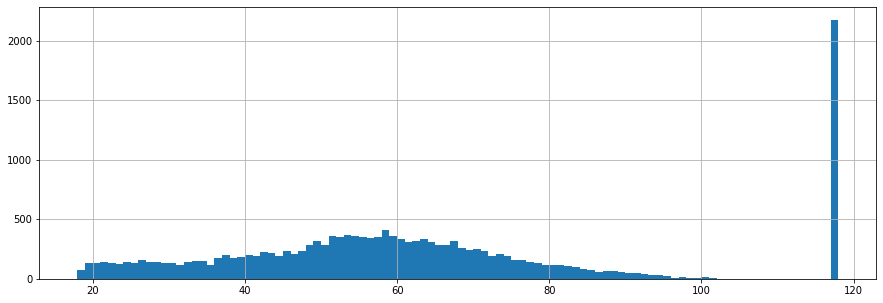

In [17]:
# check age distribution
df_profile['age'].hist(bins=100)
plt.show()

In [18]:
df_profile[df_profile['age'] > 100].groupby('age')['id'].count()

age
101       5
118    2175
Name: id, dtype: int64

There are a fair size of users who are 118 years old. That's way too impressive if it is true! My guess is that these users didn't set their birth day and default setting thought they were 118 years old. We may need more details for this. To be as unbiased as possible, here we replace the age of these people with the median age and create a column to keep their ages' characteristic.

In [19]:
# create dummies for gender
df_profile['gender'] = df_profile['gender'].replace('None', np.nan)
df_profile = pd.concat([df_profile, pd.get_dummies(df_profile['gender'], prefix='gender', dummy_na=True)], axis=1)

# remove the original column
df_profile.drop('gender', axis=1, inplace=True)

In [20]:
# create a new column for "118-year-old" user
df_profile['is_outlier_age'] = np.where(df_profile['age'] == 118, 1, 0)

# replace age with the median
df_profile['age'] = np.where(df_profile['age'] == 118, df_profile['age'].median(), df_profile['age'])

In [21]:
# create columns the year and the month member created
df_profile['year_member_created'] = df_profile['became_member_on'].astype(str).str[:4].astype(int)
df_profile['month_member_created'] = df_profile['became_member_on'].astype(str).str[4:6].astype(int)

# remove the original column
df_profile.drop('became_member_on', axis=1, inplace=True)

In [22]:
# check % missing values of income
df_profile['income'].isnull().mean()

0.12794117647058822

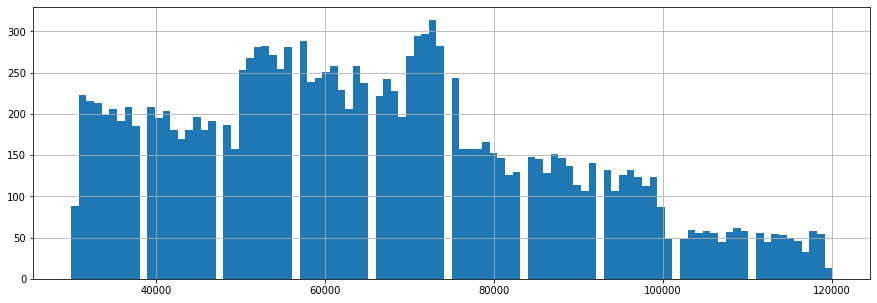

In [23]:
# check income distribution
df_profile['income'].hist(bins=100)
plt.show()

In [24]:
# create column to show the income is missing
df_profile['is_income_missing'] = df_profile['income'].isnull().astype(int)

# replace the missing income with median
df_profile['income'] = np.where(df_profile['income'].isnull(), df_profile['income'].median(), df_profile['income'])

In [25]:
# validate no missing values
assert df_profile.isnull().sum().sum() == 0

### transcript

In [26]:
# check duplicates
df_transcript[df_transcript.duplicated(keep=False)].head()

,person,event,value,time
66122,3dde94fa581145cb9f206624f1a94d5a,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,168
66123,3dde94fa581145cb9f206624f1a94d5a,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,168
66782,e9fb6ed2cecb4980ba98c86abc9c91e3,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,168
66783,e9fb6ed2cecb4980ba98c86abc9c91e3,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,168
67613,a7dc060f6fc94ca7bf71fbb188187dca,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,168


Looks like there are many duplicate rows. Because these identical transcript shared the same time and value, it is reasonable to say they are duplicates and we only need to keep the unique rows.

To make a purchase, the user would either just finish a transaction or go through the process from receiving offer, viewing offer, making transaction, to completing offer.

In [27]:
# remove duplicates
df_transcript.drop_duplicates(inplace=True)

In [28]:
# check value
df_transcript['value'].head()

0    {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2    {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3    {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
Name: value, dtype: object

In [29]:
# check types of value
transcript_values = [eval(v) for v in df_transcript['value']]
transcript_value_types = set()
for value in transcript_values:
    for t, val in value.items():
        transcript_value_types.add(t)
transcript_value_types = list(transcript_value_types)
transcript_value_types

['amount', 'offer_id', 'offer id', 'reward']

In [30]:
# make the type offer id consistent
df_transcript['value'] = df_transcript['value'].replace({'offer id': 'offer_id'}, regex=True)

In [31]:
# unstack value column and create new columns
df_transcript_offer_id = df_transcript['value'].apply(lambda x: ast.literal_eval(x)).apply(pd.Series)
df_transcript = pd.concat([df_transcript, df_transcript_offer_id], axis=1)
df_transcript.drop('value', axis=1, inplace=True)

In [32]:
# create offer time dataframe for EDA
df_offer_received = df_transcript[df_transcript['event'] == 'offer received'].drop(['event', 'amount', 'reward'], axis=1)
df_offer_viewed = df_transcript[df_transcript['event'] == 'offer viewed'].drop(['event', 'amount', 'reward'], axis=1)
df_offer_completed = df_transcript[df_transcript['event'] == 'offer completed'].drop(['event', 'amount', 'reward'], axis=1)

df_offer_time = df_offer_received.merge(df_offer_viewed, how='left', on=['person', 'offer_id'], suffixes=('_received', '_viewed'))
df_offer_time = df_offer_time.merge(df_offer_completed, how='left', on=['person', 'offer_id'])
df_offer_time.rename(columns={'time': 'time_completed'}, inplace=True)
df_offer_time = df_offer_time[['person', 'offer_id', 'time_received', 'time_viewed', 'time_completed']]

df_offer_time.head()

,person,offer_id,time_received,time_viewed,time_completed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,6.0,132.0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,6.0,NaN
2,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,624.0,NaN
3,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,18.0,NaN
4,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,0,12.0,NaN


In [33]:
# fill missing values of offer id so group by can be used to combine transaction and offer completion
df_transcript['offer_id'].fillna('', inplace=True)

# create transaction dataframe for EDA
df_transaction = df_transcript.drop(df_transcript[df_transcript.event.isin(['offer received', 'offer viewed'])].index)\
                        .groupby(['person', 'time']).agg({'offer_id': ''.join, 'amount': 'sum', 'reward': 'sum'})\
                        .reset_index()

df_transaction.head()

,person,time,offer_id,amount,reward
0,0009655768c64bdeb2e877511632db8f,228,,22.16,0.0
1,0009655768c64bdeb2e877511632db8f,414,f19421c1d4aa40978ebb69ca19b0e20d,8.57,5.0
2,0009655768c64bdeb2e877511632db8f,528,fafdcd668e3743c1bb461111dcafc2a4,14.11,2.0
3,0009655768c64bdeb2e877511632db8f,552,,13.56,0.0
4,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,10.27,2.0


In [34]:
# create df_offer for ML modeling
df_tmp_offer_received = df_transcript[df_transcript['event'] == 'offer received'][['person', 'offer_id']]
df_tmp_offer_transaction = df_transcript[df_transcript['event'] == 'offer completed'][['person', 'offer_id']]

# offer df will left join this tmp df. Thus, we can create an indicator column for offer use
df_tmp_offer_transaction['is_offer_used'] = 1

df_offer = df_tmp_offer_received.merge(df_tmp_offer_transaction, how='left', on=['person', 'offer_id'])
df_offer['is_offer_used'].fillna(0, inplace=True)
df_offer.head()

,person,offer_id,is_offer_used
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,0.0
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0


In [35]:
df_offer.shape

(85520, 3)

In [36]:
# validate no missing values
assert df_offer.isnull().sum().sum() == 0

### Combine dfs and output cleaned data

In [40]:
combined = df_offer.merge(df_portfolio, left_on='offer_id', right_on='id').drop('id', axis=1)
combined = combined.merge(df_profile, left_on='person', right_on='id').drop('id', axis=1)

combined.drop(['person', 'offer_id'], axis=1, inplace=True)
# put dependent variable to the last column
combined = combined[[col for col in combined.columns if col != 'is_offer_used'] + ['is_offer_used']]
combined.head()

,reward,difficulty,duration,mobile,email,social,web,bogo,discount,informational,...,income,gender_F,gender_M,gender_O,gender_nan,is_outlier_age,year_member_created,month_member_created,is_income_missing,is_offer_used
0,5,5,7,1,1,0,1,1,0,0,...,100000.0,1,0,0,0,0,2017,5,0,1.0
1,5,5,5,1,1,1,1,1,0,0,...,100000.0,1,0,0,0,0,2017,5,0,1.0
2,10,10,7,1,1,1,0,1,0,0,...,100000.0,1,0,0,0,0,2017,5,0,1.0
3,0,0,3,1,1,1,0,0,0,1,...,100000.0,1,0,0,0,0,2017,5,0,0.0
4,5,5,7,1,1,0,1,1,0,0,...,41000.0,0,1,0,0,0,2015,1,0,0.0


In [41]:
# validate no missing values
assert combined.isnull().sum().sum() == 0

In [42]:
# It is all good and save the file
combined.to_csv('../data/processed/data-clean.csv', index=False)

## Exploratory Analysis

In [45]:
from src.visualization import visualize

### Size

In [46]:
print(f'There are {df_portfolio.shape[0]} types of offer in total.')
print(f'There are {df_profile.shape[0]} users in total.')

There are 10 types of offer in total.
There are 17000 users in total.


### Offer Utilization

In [47]:
print(f'Each user received {df_offer.shape[0]/df_profile.shape[0]:.2f} offers in average.')

Each user received 5.03 offers in average.


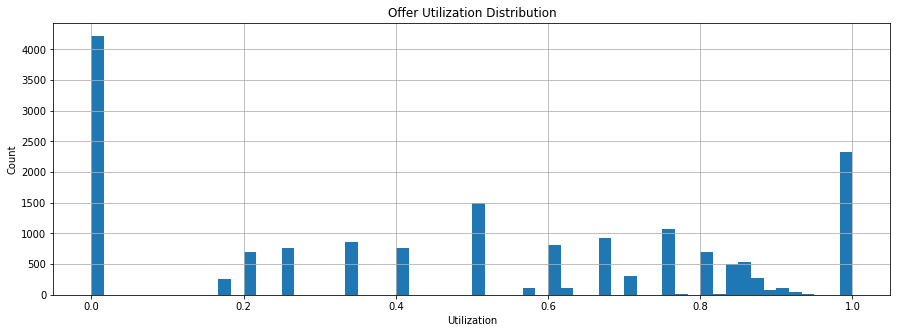

In [48]:
visualize.plot_offer_utilization(df_offer)

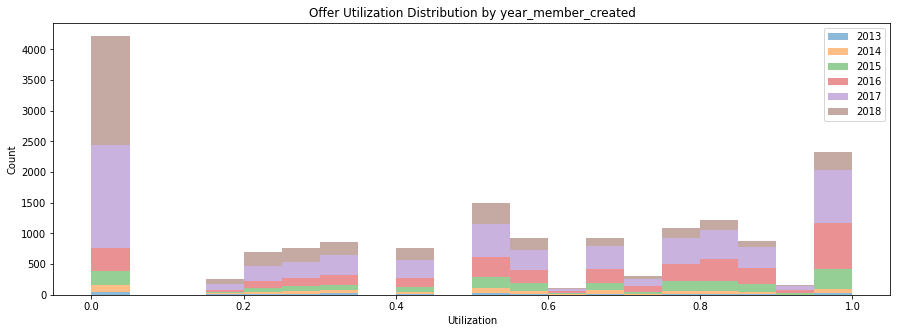

In [93]:
visualize.plot_offer_utilization_by_group(df_offer, df_profile, 'year_member_created')

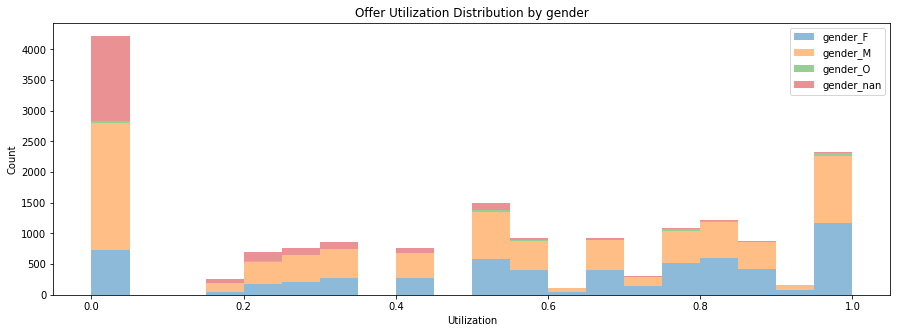

In [50]:
df_profile_gender = pd.melt(df_profile, id_vars='id', value_vars=['gender_F', 'gender_M', 'gender_O', 'gender_nan'], value_name='gender')
df_profile_gender = df_profile_gender[df_profile_gender['gender'] == 1]
df_profile_gender.drop('gender', axis=1, inplace=True)
df_profile_gender.rename(columns={'variable': 'gender'}, inplace=True)
visualize.plot_offer_utilization_by_group(df_offer, df_profile_gender, 'gender')

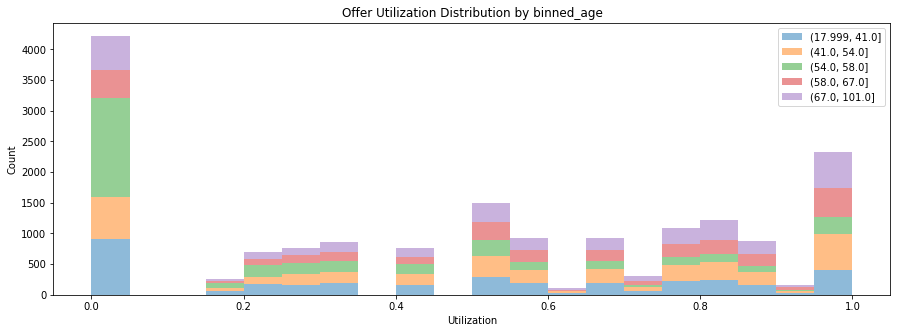

In [106]:
df_profile['binned_age'] = pd.qcut(df_profile['age'],q=[0, .2, .4, .6, .8, 1])
visualize.plot_offer_utilization_by_group(df_offer, df_profile, 'binned_age')

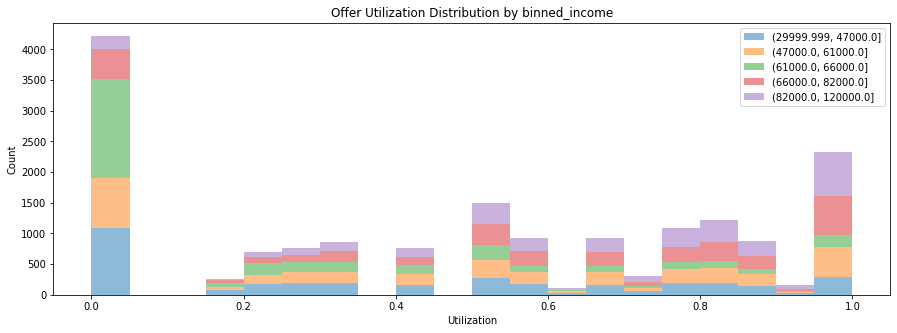

In [52]:
df_profile['binned_income'] = pd.qcut(df_profile['income'],q=[0, .2, .4, .6, .8, 1])
visualize.plot_offer_utilization_by_group(df_offer, df_profile, 'binned_income')

### Offer funnel and time

In [141]:
visualize.plot_funnel(df_offer_time)

In [142]:
visualize.plot_funnel_by_group(df_offer_time, df_profile, 'year_member_created')

In [143]:
visualize.plot_funnel_by_group(df_offer_time, df_profile_gender, 'gender')

In [144]:
visualize.plot_funnel_by_group(df_offer_time, df_profile, 'binned_age')

In [145]:
visualize.plot_funnel_by_group(df_offer_time, df_profile, 'binned_income')

In [146]:
visualize.plot_funnel_by_group(df_offer_time, df_profile, 'offer_id')

### Transaction

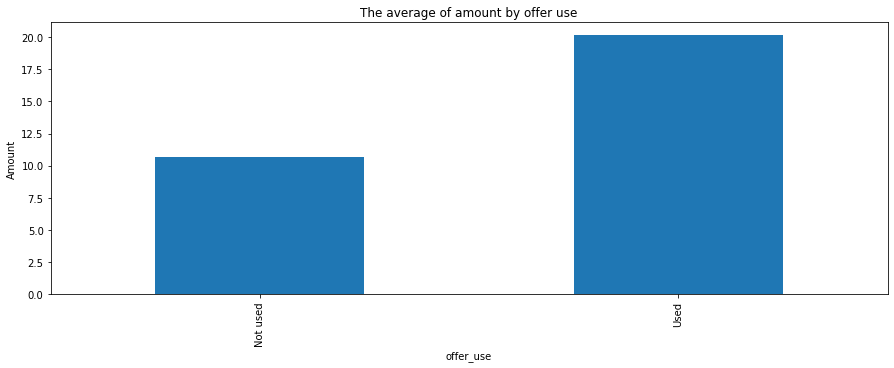

In [136]:
visualize.plot_average_amount(df_transaction, how='average')

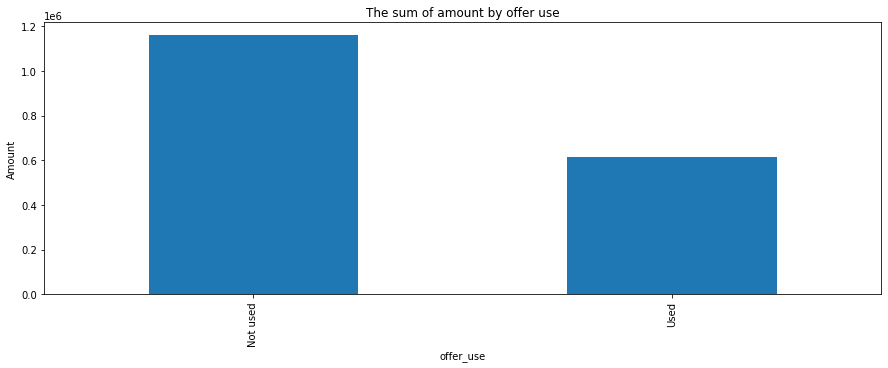

In [137]:
visualize.plot_average_amount(df_transaction, how='sum')

## Model Training

In [43]:
df_clean = pd.read_csv('../data/processed/data-clean.csv')

In [147]:
df_clean.head()

,reward,difficulty,duration,mobile,email,social,web,bogo,discount,informational,...,income,gender_F,gender_M,gender_O,gender_nan,is_outlier_age,year_member_created,month_member_created,is_income_missing,is_offer_used
0,5,5,7,1,1,0,1,1,0,0,...,100000.0,1,0,0,0,0,2017,5,0,1.0
1,5,5,5,1,1,1,1,1,0,0,...,100000.0,1,0,0,0,0,2017,5,0,1.0
2,10,10,7,1,1,1,0,1,0,0,...,100000.0,1,0,0,0,0,2017,5,0,1.0
3,0,0,3,1,1,1,0,0,0,1,...,100000.0,1,0,0,0,0,2017,5,0,0.0
4,5,5,7,1,1,0,1,1,0,0,...,41000.0,0,1,0,0,0,2015,1,0,0.0
